In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
from utils_data import PATH_HOME, PATH_DATA, CAISO
from utils_data import readin_caiso_lmp
from utils_plot import set_plt_settings

set_plt_settings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Choose nodes

In [4]:
nodes = CAISO.get_pnodes()
trading_nodes = CAISO.trading_hub_locations
moss_nodes = nodes.loc[nodes['PNode ID'].str.contains('MOSS'), 'PNode ID'].values
kern_nodes = ['SANDLOT_2_N022', 'SANDLOT_2_N024', 'SUNSPTA_7_N002']

In [6]:
nodes.shape

(1594, 2)

## 0.a Compare trading hubs
Finding: Northern and southern hubs are noticeably different; center is a lot like the northern hub

In [5]:
# read in data
data = readin_caiso_lmp(market='REAL_TIME_15_MIN', nodes=trading_nodes)
data = data.drop_duplicates().reset_index()

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]


In [6]:
data.groupby(['location', 'year'])['lmp'].describe()

count       mean         std        min        25%  \
location         year                                                         
TH_NP15_GEN-APND 2020  35136.0  31.502479   49.170596  -41.01053  19.976102   
                 2021  35040.0  50.458306   48.044049  -11.15797  32.658182   
                 2022  35040.0  89.629626  109.618376  -18.73738  50.417513   
TH_SP15_GEN-APND 2020  35136.0  32.622158   65.365213 -152.52917  19.012412   
                 2021  35040.0  48.861809   66.748910  -15.10765  29.024648   
                 2022  35040.0  84.303071  107.941109  -34.59518  45.521078   
TH_ZP26_GEN-APND 2020  35136.0  29.778924   47.892012 -222.16403  18.686420   
                 2021  35040.0  46.012215   47.492079  -61.05788  29.335528   
                 2022  35040.0  81.307644  104.819636  -49.36946  44.455107   

                             50%        75%        max  
location         year                                   
TH_NP15_GEN-APND 2020  26.603135  34.411375  1168.1033  
                 2021  45.630835  58.372505  1490.5259  
                 2022  69.404250  91.921580  2112.5910  
TH_SP15_GEN-APND 2020  25.692940  34.340275  1559.2126  
                 2021  42.462870  55.571548  1585.4513  
                 2022  65.512375  90.125927  2096.7002  
TH_ZP26_GEN-APND 2020  25.554250  33.602517  1112.9587  
                 2021  42.070325  55.000300  1448.6172  
                 2022  64.728415  87.407387  2000.0000

In [7]:
year = 2021
pn = data.lmp[(data.location == CAISO.trading_hub_locations[0]) & (data.year == year)].to_numpy() # prices are $/MWh 
ps = data.lmp[(data.location == CAISO.trading_hub_locations[1]) & (data.year == year)].to_numpy() # prices are $/MWh
pc = data.lmp[(data.location == CAISO.trading_hub_locations[2]) & (data.year == year)].to_numpy() # prices are $/MWh

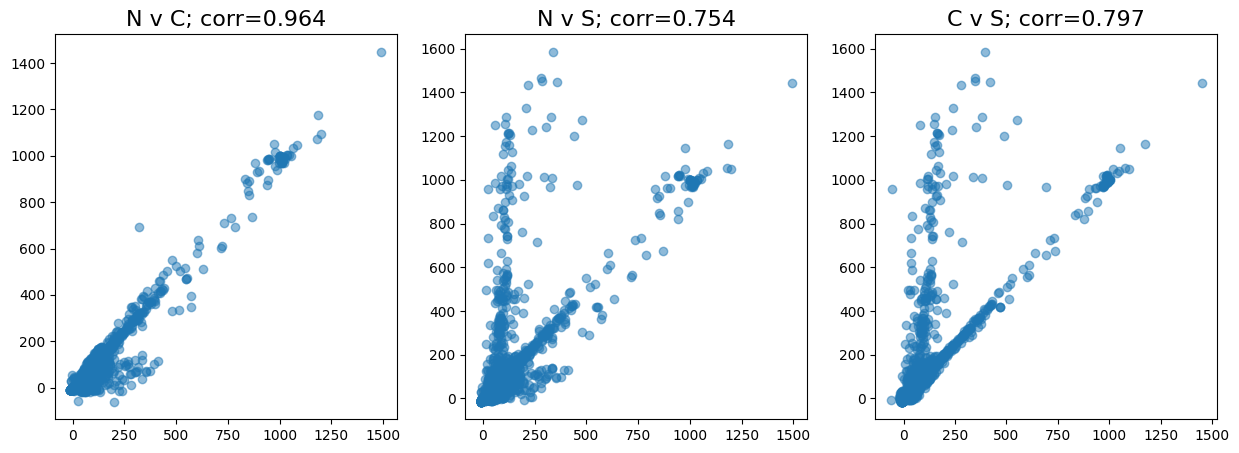

In [8]:
# How correlated are the nodes I selected?
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter(pn, pc, alpha=0.5)
ax[1].scatter(pn, ps, alpha=0.5)
ax[2].scatter(pc, ps, alpha=0.5)
ax[0].set_title(f'N v C; corr={np.round(sps.pearsonr(pn, pc)[0], 3)}')
ax[1].set_title(f'N v S; corr={np.round(sps.pearsonr(pn, ps)[0], 3)}')
ax[2].set_title(f'C v S; corr={np.round(sps.pearsonr(pc, ps)[0], 3)}')
plt.show()

## 0.b Compare Moss landing candidates
Finding: super consistent, can pick any node

In [9]:
# read in data
data = readin_caiso_lmp(market='REAL_TIME_15_MIN', nodes=moss_nodes)
data = data.drop_duplicates().reset_index()

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.52it/s]


In [10]:
data.groupby(['year', 'location'])['lmp'].describe()

count       mean         std        min        25%  \
year location                                                              
2022 MOSSLAND_5_B1  35040.0  91.249452  108.934475 -141.45456  52.380562   
     MOSSLDB_2_B1   35040.0  92.422959  109.562174 -158.06410  52.988750   
     MOSSLD_1_N055  35040.0  93.085726  110.742127 -158.06410  53.202002   

                          50%        75%        max  
year location                                        
2022 MOSSLAND_5_B1  70.798255  94.037328  2171.7163  
     MOSSLDB_2_B1   71.463230  94.901322  2219.9520  
     MOSSLD_1_N055  71.686555  95.359835  2219.9520

In [11]:
year = 2022
m1 = data.lmp[(data.location == moss_nodes[0]) & (data.year == year)].to_numpy() # prices are $/MWh 
m2 = data.lmp[(data.location == moss_nodes[1]) & (data.year == year)].to_numpy() # prices are $/MWh
m3 = data.lmp[(data.location == moss_nodes[2]) & (data.year == year)].to_numpy() # prices are $/MWh

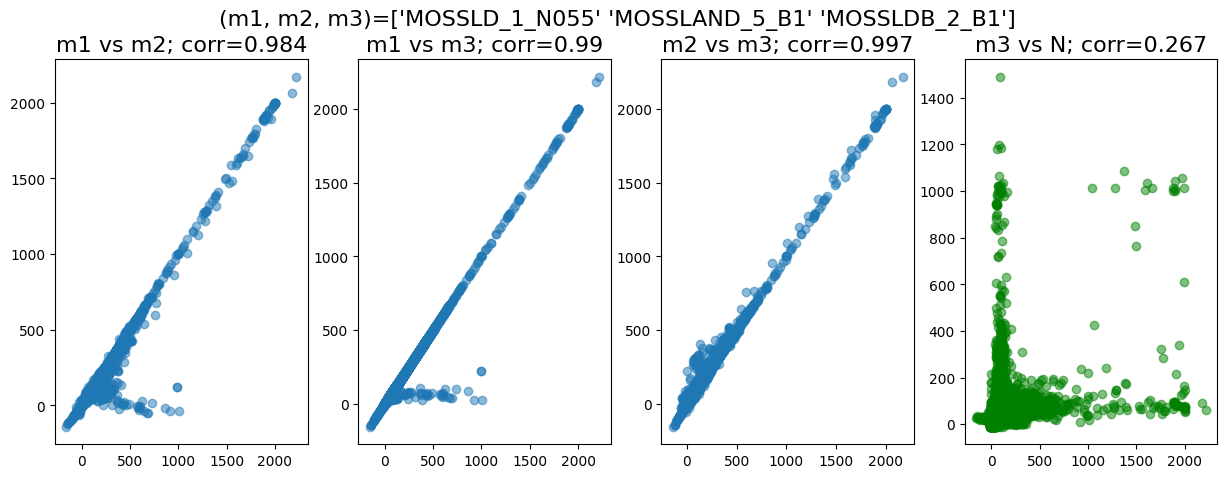

In [14]:
# How correlated are the nodes I selected?
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))
ax[0].scatter(m1, m2, alpha=0.5)
ax[1].scatter(m1, m3, alpha=0.5)
ax[2].scatter(m2, m3, alpha=0.5)
ax[3].scatter(m1, pn, alpha=0.5, color='green')
ax[0].set_title(f'm1 vs m2; corr={np.round(sps.pearsonr(m1, m2)[0], 3)}')
ax[1].set_title(f'm1 vs m3; corr={np.round(sps.pearsonr(m1, m3)[0], 3)}')
ax[2].set_title(f'm2 vs m3; corr={np.round(sps.pearsonr(m2, m3)[0], 3)}')
ax[3].set_title(f'm3 vs N; corr={np.round(sps.pearsonr(m3, pn)[0], 3)}')
plt.suptitle(f'(m1, m2, m3)={moss_nodes}')
plt.show()

## 0.c Compare Kern county candidates
Finding: super consistent, can pick any node

In [15]:
# read in data
data = readin_caiso_lmp(market='REAL_TIME_15_MIN', nodes=kern_nodes)
data = data.drop_duplicates().reset_index()

['caiso_sandlot_2_n022', 'caiso_sandlot_2_n024', 'caiso_sunspta_7_n002']


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.37it/s]


In [16]:
data.groupby(['year', 'location'])['lmp'].describe()

count       mean         std        min        25%  \
year location                                                               
2022 SANDLOT_2_N022  35040.0  85.206549  110.015688  -37.44245  45.846127   
     SANDLOT_2_N024  35040.0  85.190781  110.007210  -37.44410  45.844853   
     SUNSPTA_7_N002  35040.0  82.986011  110.114829 -153.31857  44.910015   

                           50%        75%        max  
year location                                         
2022 SANDLOT_2_N022  65.997490  91.168428  2136.9841  
     SANDLOT_2_N024  65.994560  91.159492  2136.9841  
     SUNSPTA_7_N002  65.181795  90.158315  2062.2598

In [17]:
year = 2022
k1 = data.lmp[(data.location == kern_nodes[0]) & (data.year == year)].to_numpy() # prices are $/MWh 
k2 = data.lmp[(data.location == kern_nodes[1]) & (data.year == year)].to_numpy() # prices are $/MWh
k3 = data.lmp[(data.location == kern_nodes[2]) & (data.year == year)].to_numpy() # prices are $/MWh

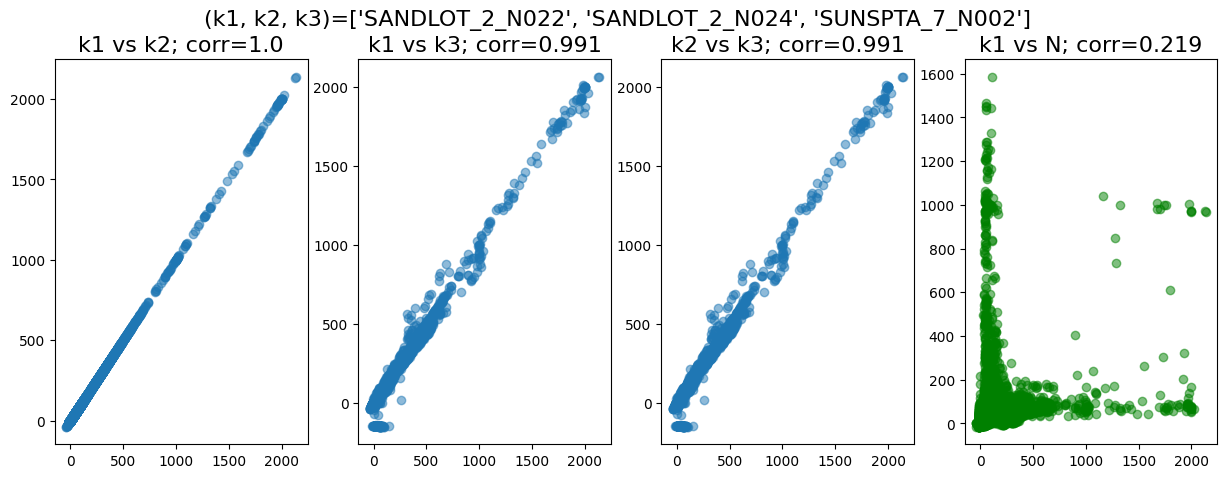

In [19]:
# How correlated are the nodes I selected?
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))
ax[0].scatter(k1, k2, alpha=0.5)
ax[1].scatter(k1, k3, alpha=0.5)
ax[2].scatter(k2, k3, alpha=0.5)
ax[3].scatter(k1, ps, alpha=0.5, color='green')
ax[0].set_title(f'k1 vs k2; corr={np.round(sps.pearsonr(k1, k2)[0], 3)}')
ax[1].set_title(f'k1 vs k3; corr={np.round(sps.pearsonr(k1, k3)[0], 3)}')
ax[2].set_title(f'k2 vs k3; corr={np.round(sps.pearsonr(k2, k3)[0], 3)}')
ax[3].set_title(f'k1 vs N; corr={np.round(sps.pearsonr(k1, ps)[0], 3)}')
plt.suptitle(f'(k1, k2, k3)={kern_nodes}')
plt.show()